<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [83]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [84]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** чем меньше батч, тем быстрее обучение на самом батче, потому что объектов меньше. Суммарно на всех батчах обучение тоже будет быстрее, потому что асимптотика обучения на одном батче явно больше, чем линейная. То есть пусть f(n) --  это асимптотика обучения, у нас k батчей, тогда $k*f(n/k) < k*f(n)/k = f(n)$

Посмотрим на какую-нибудь картинку:

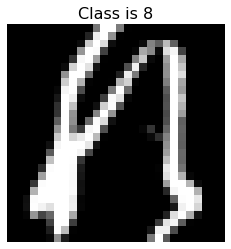

In [16]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





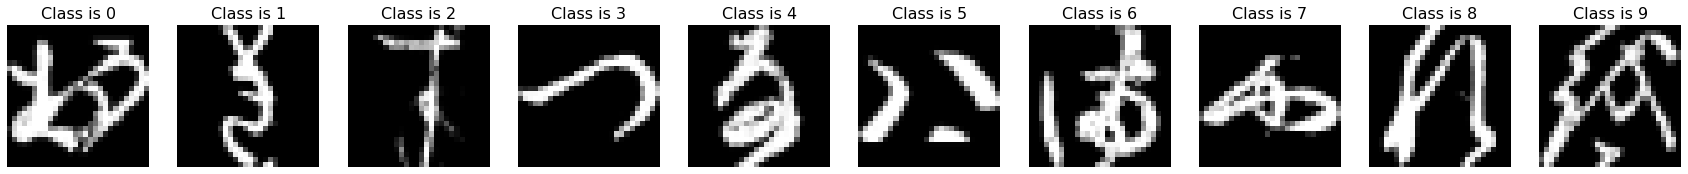

In [33]:
fig, axes = plt.subplots(1, 10, figsize=(30, 3))

for i in range(10):
    # print(i)
    for trainobj in trainset:
        if trainobj[1] == i:
            axes[i].imshow(trainobj[0].view(28, 28).numpy(), cmap="gray")
            axes[i].axis("off")
            axes[i].set_title(f"Class is {i}", fontsize=16)
            break
plt.show()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [93]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self, input_size=28*28, hidden_size1=256, hidden_size2=128, output_size=10, activation=nn.ReLU()):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.activation = activation
        self.soft_max = nn.Softmax()
        self.flatten = nn.Flatten()
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        out = self.flatten(x)
        out = self.fc1(out)
        out = self.activation(out)
        out = self.fc2(out)
        out = self.activation(out)
        out = self.fc3(out)
        logits = self.soft_max(out)
        
        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [35]:
(28*28+1)*256 + (256+1)*128 + (128+1)*10

235146

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [36]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [40]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [44]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = fc_net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss_history.append(epoch_loss)

print('Training completed')

/var/folders/nq/kpwgbkgn0bn5tf4j40dkbk7m0000gn/T/ipykernel_2240/1517210737.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = self.soft_max(out)


Training completed


In [45]:
get_accuracy(fc_net, testloader)

/var/folders/nq/kpwgbkgn0bn5tf4j40dkbk7m0000gn/T/ipykernel_2240/1517210737.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = self.soft_max(out)


0.7859

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [88]:
mean = np.mean([sample[0].numpy() for sample in trainset], axis=0)
std = np.std([sample[0].numpy() for sample in trainset], axis=0)
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std + 1e-6)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

[[[0.00123804 0.00295836 0.00485072 0.00848344 0.01427592 0.02281055
   0.03407695 0.04893041 0.06601468 0.08560808 0.10660776 0.12756737
   0.14654882 0.1554954  0.14657716 0.12159222 0.09049458 0.0647362
   0.0478952  0.03868981 0.031446   0.02399118 0.01742996 0.01143452
   0.00676003 0.00330385 0.00167287 0.0006817 ]
  [0.00279523 0.0059223  0.00962841 0.01574373 0.02625048 0.04317343
   0.06538769 0.09011611 0.1159586  0.143638   0.17254597 0.19899692
   0.21986046 0.23049453 0.22241329 0.19144584 0.14796749 0.10812113
   0.08092457 0.066844   0.05894361 0.05068322 0.04006935 0.02815248
   0.01731529 0.00891194 0.00393803 0.00152497]
  [0.00471222 0.0103837  0.01648995 0.02637877 0.0427126  0.06814047
   0.10029951 0.13356492 0.16313592 0.19168086 0.21859822 0.23913376
   0.2540626  0.26366836 0.26208153 0.2392719  0.19518949 0.14845128
   0.11282109 0.09105979 0.07987719 0.07131872 0.0615881  0.04916829
   0.03411132 0.01998514 0.00977037 0.00374306]
  [0.00717736 0.01638876 0.02

In [89]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [90]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = fc_net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss_history.append(epoch_loss)

print('Training completed')


/var/folders/nq/kpwgbkgn0bn5tf4j40dkbk7m0000gn/T/ipykernel_2240/1517210737.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = self.soft_max(out)


Training completed


In [91]:
get_accuracy(fc_net, testloader)

/var/folders/nq/kpwgbkgn0bn5tf4j40dkbk7m0000gn/T/ipykernel_2240/1517210737.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = self.soft_max(out)


0.8175

Как изменилась `accuracy` после нормализации?

Стала чуть побольше

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [96]:
fc_net = FCNet(activation=nn.Sigmoid())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)


In [97]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = fc_net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss_history.append(epoch_loss)

print('Training completed')

/var/folders/nq/kpwgbkgn0bn5tf4j40dkbk7m0000gn/T/ipykernel_2240/3483279793.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = self.soft_max(out)


Training completed


In [98]:
get_accuracy(fc_net, testloader)

/var/folders/nq/kpwgbkgn0bn5tf4j40dkbk7m0000gn/T/ipykernel_2240/3483279793.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = self.soft_max(out)


0.7473

Sigmoid accuracy = 0.7473, training time = 1m15s

In [99]:
fc_net = FCNet(activation=nn.GELU())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [100]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = fc_net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss_history.append(epoch_loss)

print('Training completed')

/var/folders/nq/kpwgbkgn0bn5tf4j40dkbk7m0000gn/T/ipykernel_2240/3483279793.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = self.soft_max(out)


Training completed


In [101]:
get_accuracy(fc_net, testloader)

/var/folders/nq/kpwgbkgn0bn5tf4j40dkbk7m0000gn/T/ipykernel_2240/3483279793.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = self.soft_max(out)


0.8705

GELU accuracy = 0.8705, training time = 1m21s

In [105]:
fc_net = FCNet(activation=nn.Tanh())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [106]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = fc_net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss_history.append(epoch_loss)

print('Training completed')

/var/folders/nq/kpwgbkgn0bn5tf4j40dkbk7m0000gn/T/ipykernel_2240/3483279793.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = self.soft_max(out)


Training completed


In [107]:
get_accuracy(fc_net, testloader)

/var/folders/nq/kpwgbkgn0bn5tf4j40dkbk7m0000gn/T/ipykernel_2240/3483279793.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = self.soft_max(out)


0.8557

Tanh accuracy = 0.8557, training time = 1m11s

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

GELU

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [109]:
fc_net = FCNet(activation=nn.GELU())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.RMSprop(fc_net.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = fc_net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss_history.append(epoch_loss)

print('Training completed')
print("RMSprop accuracy:", get_accuracy(fc_net, testloader))

/var/folders/nq/kpwgbkgn0bn5tf4j40dkbk7m0000gn/T/ipykernel_2240/3483279793.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = self.soft_max(out)


Training completed
RMSprop accuracy: 0.8779


In [110]:
fc_net = FCNet(activation=nn.GELU())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adagrad(fc_net.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = fc_net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss_history.append(epoch_loss)

print('Training completed')
print("Adagrad accuracy:", get_accuracy(fc_net, testloader))

/var/folders/nq/kpwgbkgn0bn5tf4j40dkbk7m0000gn/T/ipykernel_2240/3483279793.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = self.soft_max(out)


Training completed
Adagrad accuracy: 0.6387


Лучший accuracy у RMSprop (0.8779), чучуть хуже у Adam (0.8705), у Adagrad совсем не оч (0.6387). По времени все примерно равны

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [114]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        x = torch.max(x, torch.tensor(0.0))
        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [115]:
fc_net = FCNet(activation=CustomReLU())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = fc_net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss_history.append(epoch_loss)

print('Training completed')
print(get_accuracy(fc_net, testloader))

/var/folders/nq/kpwgbkgn0bn5tf4j40dkbk7m0000gn/T/ipykernel_2240/3483279793.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = self.soft_max(out)


Training completed
0.8146


Получилось примерно столько же и по времени, и по accuracy

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

![alt text for screen readers](images/image1.jpg "Text to show on mouseover")

"Студент делает дз в час ночи"

![alt text for screen readers](images/image2.jpg "Text to show on mouseover")

"Ночь. Улица. Фонарь. Аптека."

![alt text for screen readers](images/image3.jpg "Text to show on mouseover")

"Буратино утонул"